In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sys

In [2]:
df=pd.read_csv("Downloads/Mall_Customers.csv")

In [3]:
df.head()

,CustomerID,Genre,Age,Annual Income (k$),Spending Score (1-100)
0,1,Male,19,15,39
1,2,Male,21,15,81
2,3,Female,20,16,6
3,4,Female,23,16,77
4,5,Female,31,17,40


In [4]:
df.describe()

,CustomerID,Age,Annual Income (k$),Spending Score (1-100)
count,200.000000,200.000000,200.000000,200.000000
mean,100.500000,38.850000,60.560000,50.200000
std,57.879185,13.969007,26.264721,25.823522
min,1.000000,18.000000,15.000000,1.000000
25%,50.750000,28.750000,41.500000,34.750000
50%,100.500000,36.000000,61.500000,50.000000
75%,150.250000,49.000000,78.000000,73.000000
max,200.000000,70.000000,137.000000,99.000000


In [5]:
df.isnull().sum(axis=0)

CustomerID                0
Genre                     0
Age                       0
Annual Income (k$)        0
Spending Score (1-100)    0
dtype: int64

Changing the gender into 2 dummy variables.

In [6]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer

ct=ColumnTransformer([
    ("ohe", OneHotEncoder(), ["Genre"])
])

gender = ct.fit_transform(df)
df_gender = pd.DataFrame(gender, columns=["Female","Male"])

In [7]:
df2=pd.concat([df_gender,df],axis=1).drop(columns=["Genre","CustomerID"])
df2.head()

,Female,Male,Age,Annual Income (k$),Spending Score (1-100)
0,0.0,1.0,19,15,39
1,0.0,1.0,21,15,81
2,1.0,0.0,20,16,6
3,1.0,0.0,23,16,77
4,1.0,0.0,31,17,40


C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


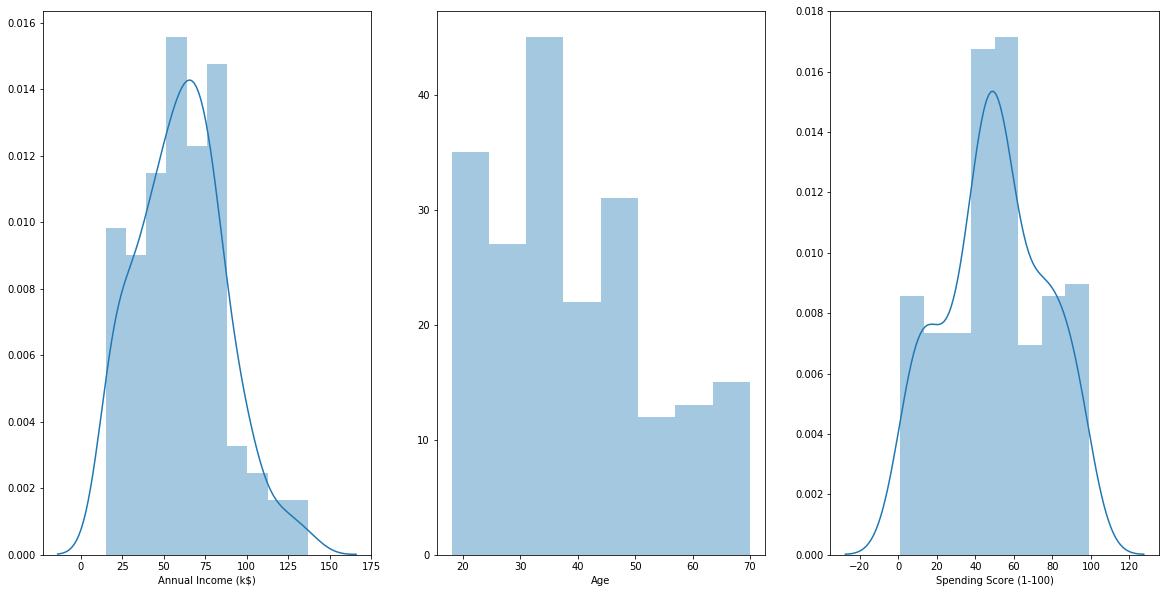

In [8]:
fig, ax = plt.subplots(figsize=(20,10),ncols=3)
sns.distplot(df2.loc[:,"Annual Income (k$)"],kde=True,ax=ax[0])
sns.distplot(df2.loc[:,"Age"],kde=False,ax=ax[1])
sns.distplot(df2.loc[:,"Spending Score (1-100)"],kde=True,ax=ax[2])
plt.show()

Distribution plot for the 3 influential features. The Annual Income is roughly centered in the 50-75K range. The majority of the people in the sample dataset is below 50 years old. The Spending Score is heavily centered right in the middle (~50) from min value of 0 and to max value of 100.

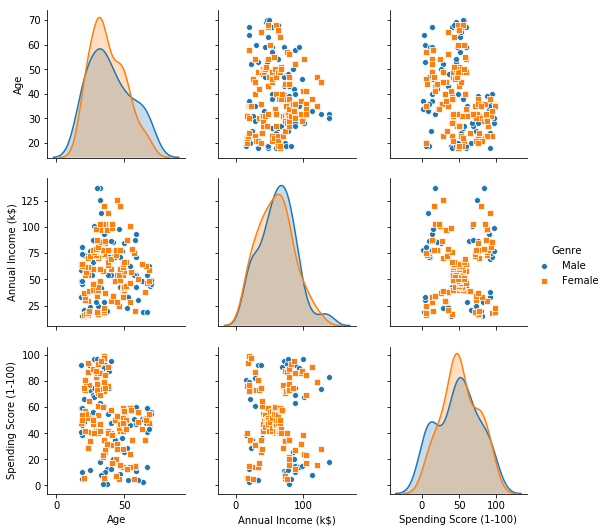

In [9]:
df_noID = df.drop(columns=["CustomerID"])
sns.pairplot(df_noID,hue="Genre",markers=["o","s"])
plt.show()

Based on the pairplot, it seems that there is no linear relationship between the 3 variables. Instead of regression, we should resort to clustering!

In [10]:
from sklearn.cluster import KMeans
from yellowbrick.cluster import KElbowVisualizer as KEV

First, we need to determine the optimal number of clusters using the elbow method. The metric used for our analysis is the sum of squared distances. The Euclidean distance is calculated between each point and the cluster centers and, subsequently, attempt to minimize the distance as much as possible. The cluster center is then constantly moved to another coordinate until the smallest distance is obtained and thus the centers do not move anymore. 

We do not necessarily want to choose the lowest distortion score. As the elbow starts to plateau, the SSD relatively decreases at a slower rate. This equates to more clusters with  fewer constituents and may lead to multiple similar clusters inconveniently separated from negligble differences.

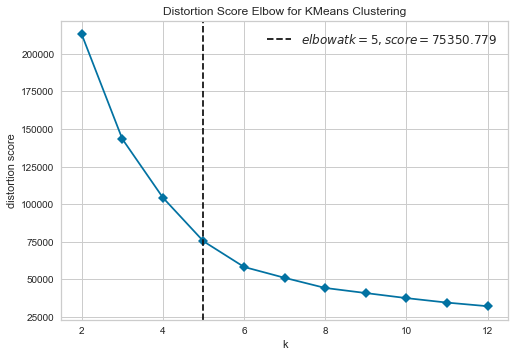

In [11]:
df_nogender = df_noID.drop(columns=["Genre"])

kmeans = KMeans(init='k-means++', max_iter=300, n_init=10, random_state=0)
elbow = KEV(kmeans, k=12, timings=False)

fig, ax = plt.subplots()
elbow.fit(df_nogender)
ax = elbow.show()

In [12]:
kmeans = KMeans(n_clusters=5, init="k-means++",max_iter=300,random_state=42)
km_pred = kmeans.fit_predict(df_nogender)

df3 = pd.concat([df2,pd.DataFrame(km_pred,columns=["Cluster"])],axis=1)
print("Count per cluster:\n", 
      df3["Cluster"].value_counts())
df3.head()

Count per cluster:
 3    79
1    39
2    37
0    23
4    22
Name: Cluster, dtype: int64


,Female,Male,Age,Annual Income (k$),Spending Score (1-100),Cluster
0,0.0,1.0,19,15,39,0
1,0.0,1.0,21,15,81,4
2,1.0,0.0,20,16,6,0
3,1.0,0.0,23,16,77,4
4,1.0,0.0,31,17,40,0


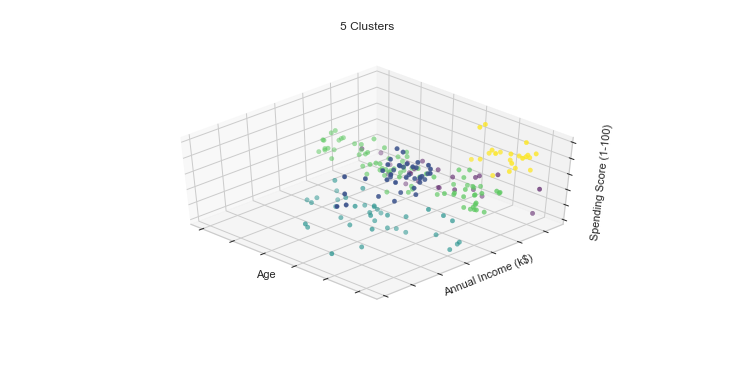

In [13]:
from mpl_toolkits.mplot3d import Axes3D

def visualize_clusters(df):
    fig = plt.figure(figsize=(10,5))
    ax = Axes3D(fig,elev=50,azim=135)
    kmeans.fit(df)
    labels = kmeans.labels_
    ax.scatter(df.loc[:,"Age"],df.loc[:,"Annual Income (k$)"],df.loc[:,"Spending Score (1-100)"],
              c=labels.astype(np.float),cmap='viridis')

    ax.w_xaxis.set_ticklabels([])
    ax.w_yaxis.set_ticklabels([])
    ax.w_zaxis.set_ticklabels([])
    ax.set_xlabel("Age")
    ax.set_ylabel("Annual Income (k$)")
    ax.set_zlabel("Spending Score (1-100)")
    ax.set_title("5 Clusters")
    ax.dist = 15

visualize_clusters(df_nogender)

It is hard to visualize the clusters in 3D graph (when 3 features are included). Not only are the clusters overlapping one another but also some of the datapoints are far away from the majority of the datapoints in the same clusters (refer to purple cluster) suggesting that one of the feature has a skewing variance. If we see the describe table above, we certainly do see that the Age has lower variance compared to Annual Income and Spending Score. Furthermore, we prematurely removed the gender variable from the kmeans. 


For easier visualization and feature selection, we can use PCA, an unsupervised learning dimenstionality reduction approach perfectly suitable to pair with KMeans.

In [14]:
from sklearn.decomposition import PCA

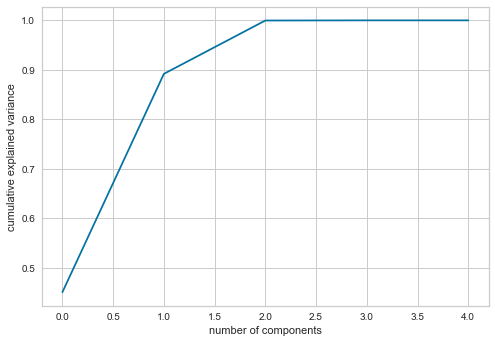

In [15]:
pca = PCA().fit(df2)
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance')
plt.show()

The explained variance begins to plateau after 2 components. We want to minimize the total number of components as much as possible as such translates to the smallest number of dimensions that contains the most information, or in other words, highest variance. 

In [16]:
pca = PCA(n_components=2)

pca = pca.fit(df2)
pca_t = pca.transform(df2)

df4 = pd.concat([df3, pd.DataFrame(pca_t,columns=["pca1","pca2"])],axis=1)
df4.head()

,Female,Male,Age,Annual Income (k$),Spending Score (1-100),Cluster,pca1,pca2
0,0.0,1.0,19,15,39,0,-31.869381,-33.001079
1,0.0,1.0,21,15,81,4,0.765592,-56.841935
2,1.0,0.0,20,16,6,0,-57.407825,-13.126987
3,1.0,0.0,23,16,77,4,-2.167187,-53.479276
4,1.0,0.0,31,17,40,0,-32.173249,-30.389820


In [17]:
print("Explained variance:\n ",pca.explained_variance_)
components = pd.DataFrame(pca.components_, columns = df2.columns)
components

Explained variance:
  [700.26450987 684.33354753]


,Female,Male,Age,Annual Income (k$),Spending Score (1-100)
0,0.000333,-0.000333,-0.188980,0.588604,0.786022
1,-0.001579,0.001579,0.130958,0.808401,-0.573876


The components define the principal axes of the data or, in other words, direction of the vector. The explained variance defines the squared-length of the vector where the magnitude of the length indicate how important that axis is in describing the distribution of the data.

In [18]:
import math

def get_important_features(transformed_features, components_, columns):
    
    num_columns = len(columns)
    
    xvector = components_[0] * max(transformed_features[:,0])
    yvector = components_[1] * max(transformed_features[:,1])
    
    important_features = {columns[i] : math.sqrt(xvector[i]**2 + yvector[i]**2) for i in range(num_columns)}
    important_features = sorted(zip(important_features.values(), important_features.keys()), reverse=True)
    print("Features by importance:\n", important_features)
    
get_important_features(pca_t,pca.components_,df2.columns)

Features by importance:
 [(77.04563014624392, 'Annual Income (k$)'), (72.922937494085, 'Spending Score (1-100)'), (17.19014782055321, 'Age'), (0.12765738603851726, 'Male'), (0.12765738603850396, 'Female')]


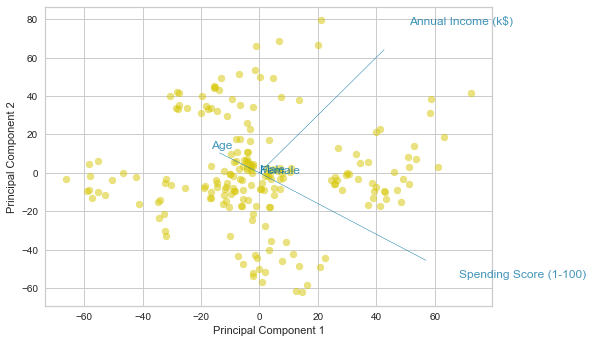

In [19]:
def draw_vectors(transformed_features, components_, columns):
    
    num_columns = len(columns)
    
    xvector = components_[0] * max(transformed_features[:,0])
    yvector = components_[1] * max(transformed_features[:,1])
    
    ax = plt.axes()

    for i in range(num_columns):
        
        plt.arrow(0, 0, xvector[i], yvector[i], color='b', width=0.0005, head_width=0.02, alpha=0.75)
        plt.text(xvector[i]*1.2, yvector[i]*1.2, list(columns)[i], color='b', alpha=0.75)

    return ax

ax = draw_vectors(pca_t, pca.components_, df2.columns.values)

T_df = pd.DataFrame(pca_t)
T_df.columns = ['component1', 'component2']

plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.scatter(T_df['component1'], T_df['component2'], color='y', alpha=0.5)
plt.show()

The biplot shows that "Annual Income" and "Spending Score" are the two most important components, consistent with the calculated important features.

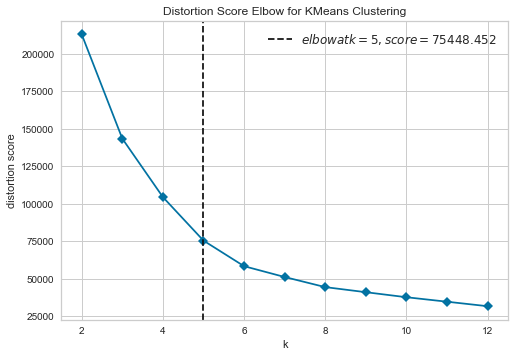

In [20]:
kmeans = KMeans(init='k-means++', max_iter=300, n_init=10, random_state=0)
elbow = KEV(kmeans, k=12, timings=False)

fig, ax = plt.subplots()
elbow.fit(df2)
ax = elbow.show()

In [21]:
kmeans = KMeans(n_clusters=5, init="k-means++",max_iter=300,random_state=42)
km_pred = kmeans.fit_predict(df2)

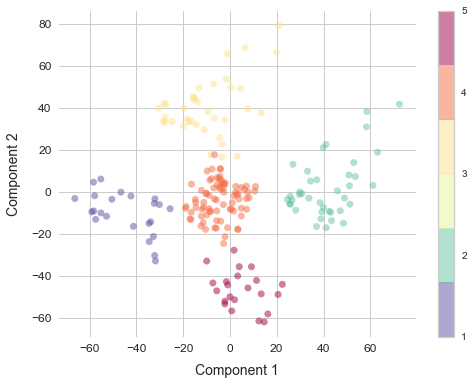

In [22]:
fig, ax = plt.subplots(figsize = (8, 6))

plt.scatter(pca_t[:, 0], pca_t[:, 1],
            c=km_pred+1, 
            edgecolor="none", 
            cmap=plt.cm.get_cmap("Spectral_r", 6),
            alpha=0.5)
        
plt.gca().spines["top"].set_visible(False)
plt.gca().spines["right"].set_visible(False)
plt.gca().spines["bottom"].set_visible(False)
plt.gca().spines["left"].set_visible(False)

plt.xticks(size=12)
plt.yticks(size=12)

plt.xlabel("Component 1", size = 14, labelpad=10)
plt.ylabel("Component 2", size = 14, labelpad=10)

plt.colorbar(ticks=[1, 2, 3, 4, 5, 6]);

plt.show()

Identify the coordinates of the cluster centers.

In [23]:
clusters = pd.DataFrame(kmeans.cluster_centers_, columns = df2.columns)
clusters["Clusters"]=clusters.index+1
clusters

,Female,Male,Age,Annual Income (k$),Spending Score (1-100),Clusters
0,0.608696,0.391304,45.217391,26.304348,20.913043,1
1,0.538462,0.461538,32.692308,86.538462,82.128205,2
2,0.486486,0.513514,40.324324,87.432432,18.189189,3
3,0.582278,0.417722,43.126582,54.822785,49.835443,4
4,0.590909,0.409091,25.272727,25.727273,79.363636,5


Each cluster represents a unique shopping habit with the "Annual Income" and "Spending Score" as the most influential features. Clusters 1,2, and 4 are the "normal" or "expected" clusters; people who have a lower income spend less, have a higher income spend more, and have an average income spend more or less, respectively. On the other hand, Clusters 3 and 5 are less intuitive groups. Cluster 3 shows people who earn high income but have low spending while Cluster 5 shows people who earn a low income but have high spending!